# Loading MNIST Data

In [98]:
import pickle
import gzip
import numpy as np

In [99]:
def load_data():
    """ Loads the MNIST data and returns it as a tuple of the form
    (training_data, validation_data, testing_data)
    """
    f = gzip.open('../data/mnist.pkl.gz', 'rb')
    train, val, test = pickle.load(f, encoding="latin1")
    f.close()
    return (train, val, test)


def load_data_wrapper():
    train, val, test = load_data()
    train_input = [np.reshape(x, (len(x), 1)) for x in train[0]] # Reshape input (n, ) to (n, 1)
    train_result = [one_hot_encode(y) for y in train[1]]
    train_data = list(zip(train_input, train_result))
    val_input = [np.reshape(x, (len(x), 1)) for x in val[0]] # Reshape input (n, ) to (n, 1)
    val_result = [one_hot_encode(y) for y in val[1]]
    val_data = list(zip(val_input, val_result))
    test_input = [np.reshape(x, (len(x), 1)) for x in test[0]] # Reshape input (n, ) to (n, 1)
    test_result = [one_hot_encode(y) for y in test[1]]
    test_data = list(zip(test_input, test_result))

    return (train_data, val_data, test_data)


def one_hot_encode(n): 
    """Converts a decimal digit into a one-hot encoded vector and returns the vector.
    
    This is the output that we are trying to match for each digit during prediction.
    """
    v = np.zeros((10, 1))
    v[n] = 1.0
    return v



# Regular Network Implementation


In [100]:
import random

In [101]:
class Network():
    def __init__(self, sizes, activation = "Sigmoid"):
        self.sizes = sizes
        self.num_layers = len(sizes)
        self.biases = [np.random.randn(y, 1) for y in sizes[1:]]
        self.weights = [np.random.randn(x, y) for x, y in zip(sizes[1:], sizes[:-1])] # Second layer parameter x comes before first layer parameter y to enable matrix multiplication
        self.activation_type = activation

    def forward(self, x):
        for i in range(self.num_layers - 1):
            b = self.biases[i]
            w = self.weights[i]
            x = self.activation(w @ x + b)
        return x
    
    # Use Leaky RELU by default
    def activation(self, x):
        if (self.activation_type == "Leaky RELU"):
            return np.where(x > 0, x, x * 0.03)
        elif (self.activation_type == "Sigmoid"):
            return self.sigmoid(x)
        
        raise Exception("Activation Function Type Does Not Exist")

    def sigmoid(self, z):
        return 1.0/(1.0+np.exp(-z))
    
    def activation_derivative(self, x):
        if (self.activation_type == "Sigmoid"):
            return self.sigmoid(x)*(1-self.sigmoid(x))


        raise Exception("Activation Function Type Does Not Exist")

    def SGD(self, train_data, epochs, batch_size, alpha, test_data = None):
        n = len(train_data)

        for i in range(epochs):
            random.shuffle(train_data)
            batches = [train_data[k: k + batch_size] for k in range(0, n, batch_size)]
            
            for batch in batches:
                self.update(batch, alpha)
            
            if (test_data):
                print("Epoch", i + 1, "Accuracy: ", self.evaluate(test_data))
            else:
                print("Epoch ", i + 1, "Complete")
        
    def evaluate(self, data):
        preds = [1 if (np.argmax(self.forward(x)) == np.argmax(y)) else 0 for x,y in data]
        return np.mean(preds)

    def update(self, batch, alpha):
        delta_b = [np.zeros(b.shape) for b in self.biases]
        delta_w = [np.zeros(w.shape) for w in self.weights]

        for x,y in batch:
            del_b, del_w = self.backprop(x, y)
            delta_b = [change_b + new_change_b for change_b, new_change_b in zip(delta_b, del_b)]
            delta_w = [change_w + new_change_w for change_w, new_change_w in zip(delta_w, del_w)]
        
        self.weights = [w - alpha*(delw)/len(batch) for w, delw in zip(self.weights, delta_w)]
        self.biases = [b - alpha*(delb)/len(batch) for b, delb in zip(self.biases, delta_b)]
        
    def backprop(self, x, y):
        """Return a tuple ``(nabla_b, nabla_w)`` representing the
        gradient for the cost function C_x.  ``nabla_b`` and
        ``nabla_w`` are layer-by-layer lists of numpy arrays, similar
        to ``self.biases`` and ``self.weights``."""
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        # feedforward
        activation = x
        activations = [x] # list to store all the activations, layer by layer
        zs = [] # list to store all the z vectors, layer by layer
        for b, w in zip(self.biases, self.weights):
            z = np.dot(w, activation) + b
            zs.append(z)
            activation = self.sigmoid(z)
            activations.append(activation)
        # backward pass
        delta = self.cost_derivative(activations[-1], y) * \
            self.activation_derivative(zs[-1])
        nabla_b[-1] = delta
        nabla_w[-1] = np.dot(delta, activations[-2].transpose())
        # Note that the variable l in the loop below is used a little
        # differently to the notation in Chapter 2 of the book.  Here,
        # l = 1 means the last layer of neurons, l = 2 is the
        # second-last layer, and so on.  It's a renumbering of the
        # scheme in the book, used here to take advantage of the fact
        # that Python can use negative indices in lists.
        for l in range(2, self.num_layers):
            z = zs[-l]
            sp = self.activation_derivative(z)
            delta = np.dot(self.weights[-l+1].transpose(), delta) * sp
            nabla_b[-l] = delta
            nabla_w[-l] = np.dot(delta, activations[-l-1].transpose())
        return (nabla_b, nabla_w)

    def cost_derivative(self, output_activations, y):
        """Return the vector of partial derivatives \partial C_x /
        \partial a for the output activations."""
        return (output_activations-y)


In [198]:
a, b, c = load_data_wrapper()

# Testing

In [1]:
import data_loader
from simple_network import Network

In [5]:
train, val, test = data_loader.load_data_wrapper()

In this file
/Users/vishnesh/Master/01 - College/06 - Spring '24/PSYC 4803 - Physics of Cognition/Project/bio-inspired-networks/src


In [19]:
print(train[0][0].shape)

(784, 1)


In [21]:
#import data_loader
train, val, test = data_loader.load_data_wrapper()

net = Network([784, 30, 10])
net.SGD(train, 15, 10, 3.0, test_data = test)


In this file
/Users/vishnesh/Master/01 - College/06 - Spring '24/PSYC 4803 - Physics of Cognition/Project/bio-inspired-networks/src


KeyboardInterrupt: 

In [43]:
%matplotlib inline
import matplotlib.pyplot as plt

In [214]:
no += 1

My algorithm thinks the number is  7
The number should be 7


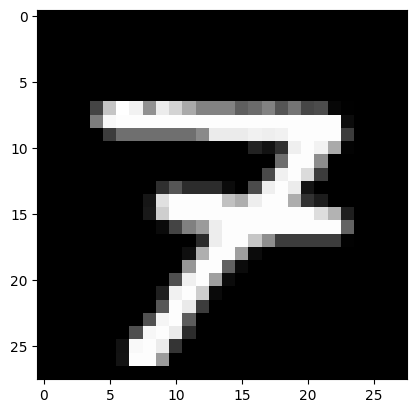

In [215]:
x = test[no][0]
ans = np.argmax(test[no][1])
print("My algorithm thinks the number is ", np.argmax(net.forward(x)))
x = np.array(x).reshape(28, 28)

plt.imshow(x, cmap='gray')
print("The number should be", ans)

